In [12]:
import kagglehub
import numpy as np
import os

# Download latest version
path = kagglehub.dataset_download("ritalin56/kaggles-most-upvoted-datasets-overview")

print("Path to dataset files:", path)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Path to dataset files: /kaggle/input/kaggles-most-upvoted-datasets-overview
/kaggle/input/kaggles-most-upvoted-datasets-overview/kaggle_top_100_dataset.csv


In [13]:
import pandas as pd
try:
    df = pd.read_csv('/kaggle/input/kaggles-most-upvoted-datasets-overview/kaggle_top_100_dataset.csv', encoding='latin1', sep=';')
except UnicodeDecodeError:
    df = pd.read_csv('/kaggle/input/kaggles-most-upvoted-datasets-overview/kaggle_top_100_dataset.csv', encoding='cp1252', sep=';')
df.head()

,Dataset_Name,Author,Last_Update,Usability,File_Count,Data_Type,Size,Upvote,Rank
0,Bitcoin Historical Data,Zielak,2025,100,1,CSV,98 MB,3693,Gold
1,International football results from 1872 to 2025,Mart Jürisoo,2025,100,4,CSV,1 MB,2315,Gold
2,Fruits-360 dataset,Mihai Oltean,2025,88,240356,other,4 GB,3133,Gold
3,Formula 1 World Championship (1950 - 2024),Vopani,2025,100,14,CSV,7 MB,1937,Gold
4,arXiv Dataset,Cornell University,2025,88,1,JSON,2 GB,1480,Bronze


In [14]:
df.describe()

,Last_Update,Usability,File_Count,Upvote
count,99.000000,99.000000,99.000000,99.000000
mean,2019.666667,86.535354,13430.535354,3325.989899
std,2.420153,11.292325,78438.982957,5298.328014
min,2016.000000,50.000000,1.000000,1401.000000
25%,2018.000000,79.000000,1.000000,1619.000000
50%,2019.000000,88.000000,2.000000,2229.000000
75%,2022.000000,97.000000,8.000000,3204.500000
max,2025.000000,100.000000,717120.000000,52058.000000


In [15]:
# Explore feature types
print(df.info())

# Check class distribution of the target variable (assuming the last column is the target)
print("\nClass Distribution:")
print(df.iloc[:, -1].value_counts())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Dataset_Name  99 non-null     object
 1   Author        99 non-null     object
 2   Last_Update   99 non-null     int64 
 3   Usability     99 non-null     int64 
 4   File_Count    99 non-null     int64 
 5   Data_Type     99 non-null     object
 6   Size          99 non-null     object
 7   Upvote        99 non-null     int64 
 8   Rank          99 non-null     object
dtypes: int64(4), object(5)
memory usage: 7.1+ KB
None

Class Distribution:
Rank
Gold      89
Bronze     5
Silver     5
Name: count, dtype: int64

Missing Values:
Dataset_Name    0
Author          0
Last_Update     0
Usability       0
File_Count      0
Data_Type       0
Size            0
Upvote          0
Rank            0
dtype: int64


In [16]:
# prompt: assign gold : 3 , silver :2 , Bronze : 1 rank in Rank column and plot bar graph for Author vs Rank

# Function to assign rank based on medal type
def assign_rank(medal):
  if medal == 'Gold':
    return 3
  elif medal == 'Silver':
    return 2
  elif medal == 'Bronze':
    return 1
  else:
    return 0 # Or handle other cases if needed

# Apply the function to create the 'Rank' column
df['Medal'] = df['Rank'].apply(assign_rank)

# Group by Author and sum the ranks
author_ranks = df.groupby('Author')['Medal'].sum().sort_values(ascending=False)

author_ranks.head()

,Medal
Author,
Murat KOKLU,31
UCI Machine Learning,21
Larxel,6
Jessica Li,6
SRK,6


In [18]:
# prompt: bar graph size vs usability

# Ensure 'Size' column is numeric (you might need to convert it depending on its format)
# Example conversion if 'Size' is in string format like '1.2 GB', '500 MB' etc.
# You would need to parse the string and convert to a consistent unit (e.g., MB)

# For simplicity, let's assume 'Size' is already in a comparable numeric format (e.g., MB)
# If not, you need to add the necessary conversion code here.
# Example:
def convert_size_to_mb(size_str):
  if isinstance(size_str, str):
    size_str = size_str.strip().upper()
    if 'GB' in size_str:
      return float(size_str.replace('GB', '').strip()) * 1024
    elif 'MB' in size_str:
      return float(size_str.replace('MB', '').strip())
    elif 'KB' in size_str:
      return float(size_str.replace('KB', '').strip()) / 1024

df['Size_MB'] = df['Size'].apply(convert_size_to_mb)
df_filtered = df.dropna(subset=['Usability', 'Size_MB']) # Use 'Size_MB' for plotting


df_filtered[['Size_MB', 'Usability']].head()

,Size_MB,Usability
0,98.0,100
1,1.0,100
2,4096.0,88
3,7.0,100
4,2048.0,88


In [30]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
le_type = LabelEncoder()
df['Type_encoded'] = le_type.fit_transform(df['Data_Type'].astype(str))
df['Upvote_per_file'] = df['Upvote'] / df['File_Count'].replace(0, 1)
df['Upvote_per_MB'] = df['Upvote'] / df['Size_MB'].replace(0, 0.001)

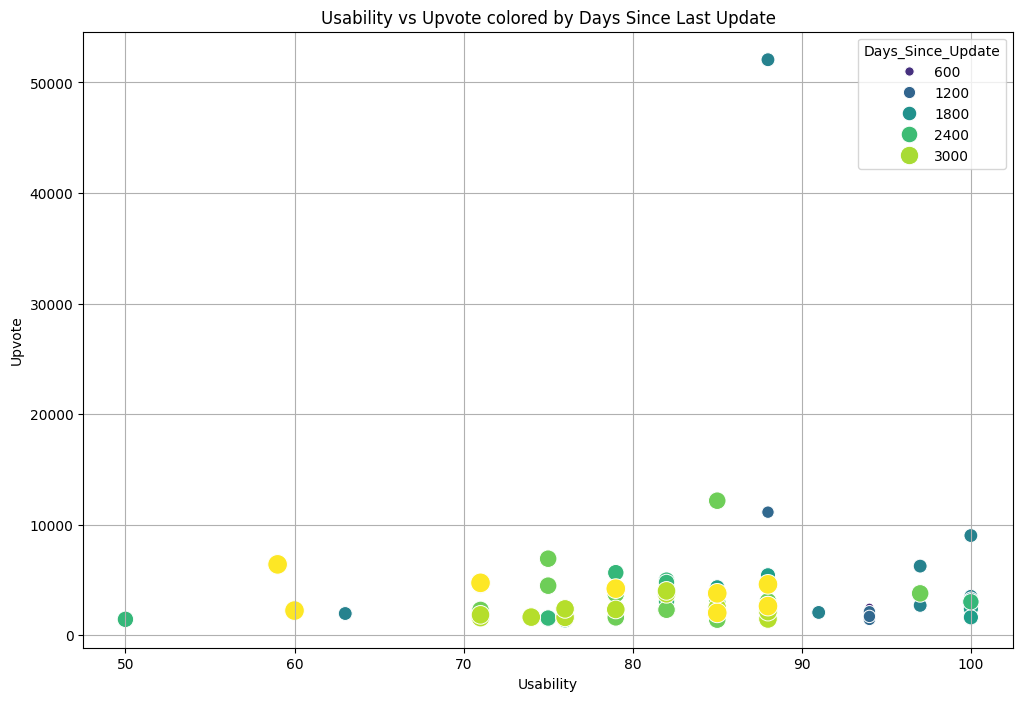

In [31]:
# prompt: graph for Last_Update vs Usability vs Upvote

import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Upvote' to numeric, coercing errors
df['Upvote'] = pd.to_numeric(df['Upvote'], errors='coerce')

# Convert 'Last_Update' to datetime objects, coercing errors
# Assuming 'Last_Update' contains only the year
df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='%Y', errors='coerce')

# Calculate the number of days since the last update
df['Days_Since_Update'] = (pd.to_datetime('today') - df['Last_Update']).dt.days

# Drop rows where 'Upvote' or 'Days_Since_Update' is NaN (due to coercion errors)
df_filtered = df.dropna(subset=['Usability', 'Upvote', 'Days_Since_Update'])

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_filtered, x='Usability', y='Upvote', hue='Days_Since_Update', size='Days_Since_Update', sizes=(20, 200), palette='viridis')
plt.title('Usability vs Upvote colored by Days Since Last Update')
plt.xlabel('Usability')
plt.ylabel('Upvote')
plt.grid(True)
plt.show()

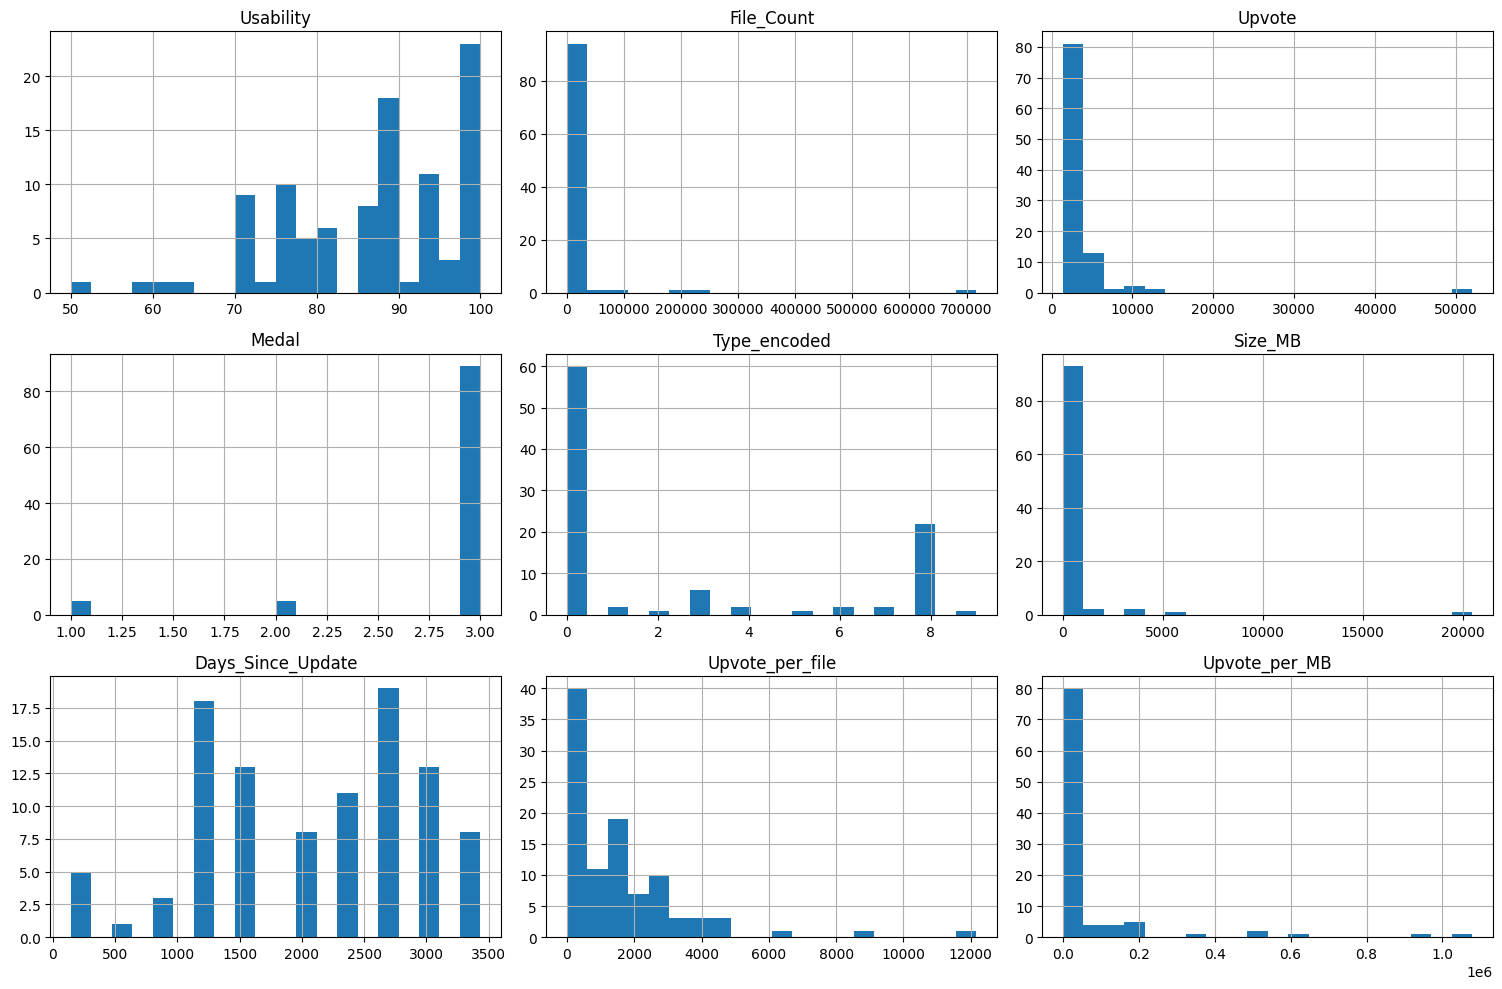

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for histogram visualization
df_numeric = df.select_dtypes(include=[np.number])

# Plot histograms for each numeric feature
df_numeric.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

<ipython-input-33-d30b397e8305>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_ranks.index, y=author_ranks.values, palette='viridis')


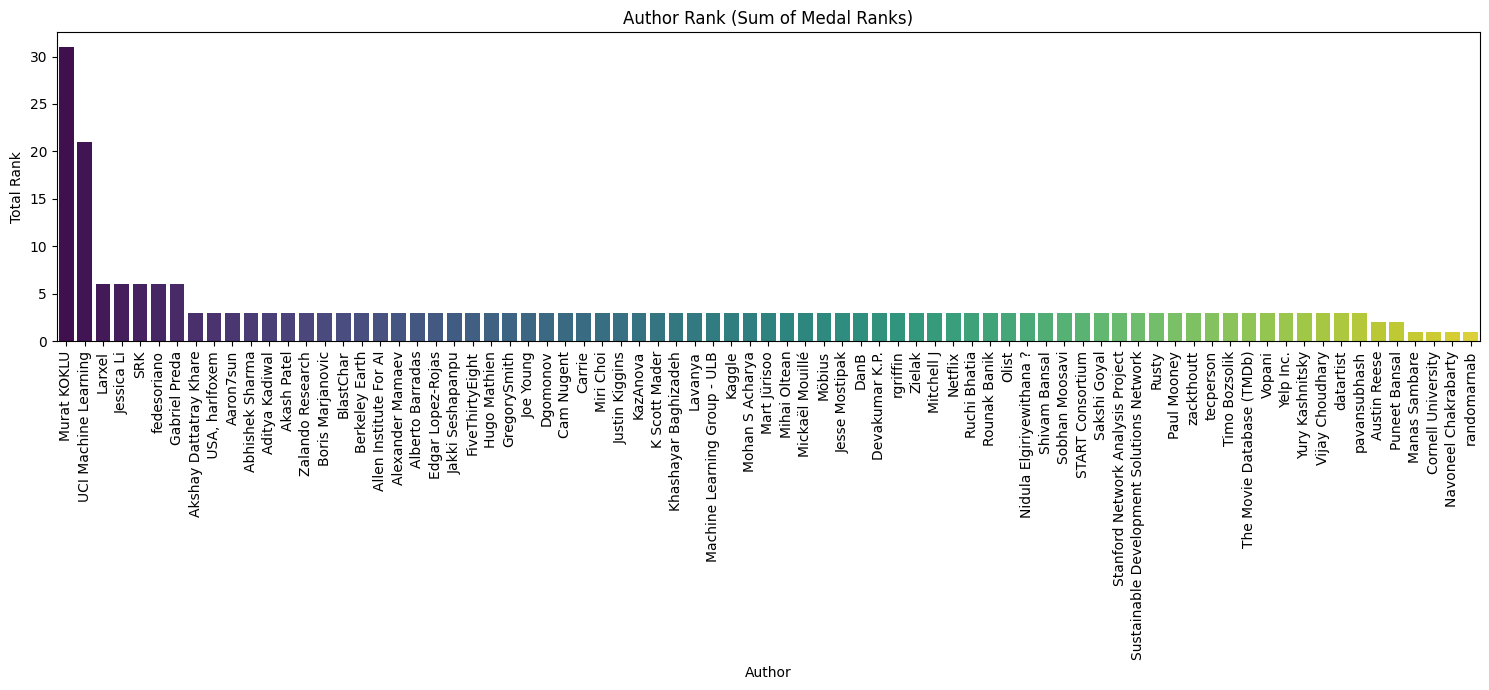

In [33]:
# Plot the bar graph
plt.figure(figsize=(15, 7))
sns.barplot(x=author_ranks.index, y=author_ranks.values, palette='viridis')
plt.title('Author Rank (Sum of Medal Ranks)')
plt.xlabel('Author')
plt.ylabel('Total Rank')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

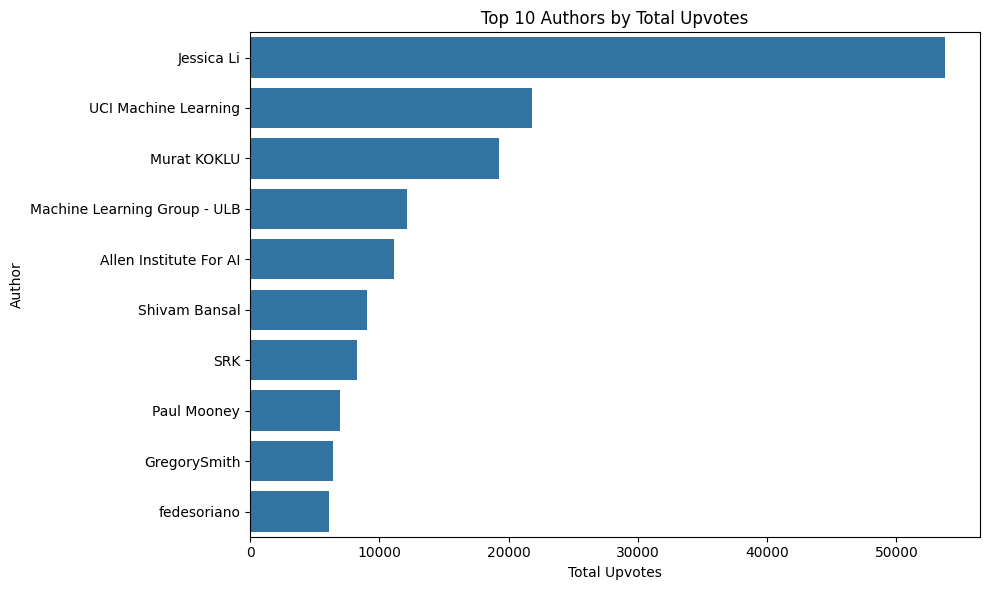

In [34]:
top_authors = df.groupby("Author")["Upvote"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title("Top 10 Authors by Total Upvotes")
plt.xlabel("Total Upvotes")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

<ipython-input-35-c455f79fe351>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_filtered.groupby(['Usability_Bin', 'Days_Since_Update_Bin'])['Upvote'].mean().reset_index()


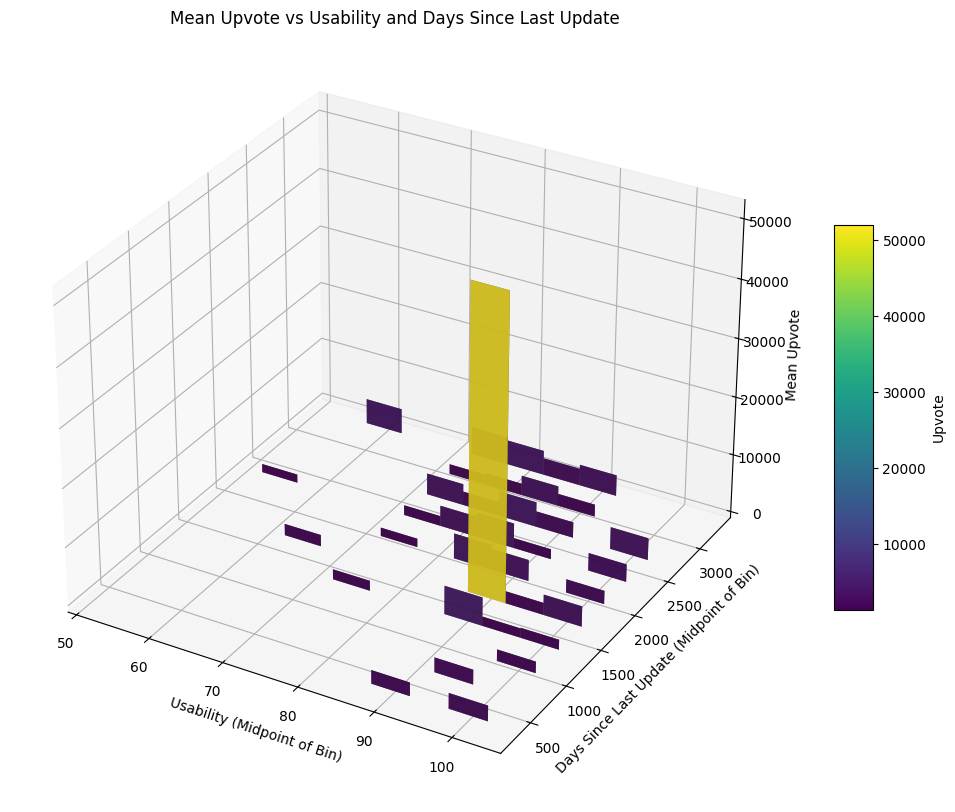

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for 3D bar plot
df_filtered['Usability_Bin'] = pd.cut(df_filtered['Usability'], bins=10)
df_filtered['Days_Since_Update_Bin'] = pd.cut(df_filtered['Days_Since_Update'], bins=10)

# Group by bins and get mean of Upvote
grouped_data = df_filtered.groupby(['Usability_Bin', 'Days_Since_Update_Bin'])['Upvote'].mean().reset_index()

# Convert bins to midpoints
grouped_data['Usability_Bin_Mid'] = grouped_data['Usability_Bin'].apply(lambda x: x.mid)
grouped_data['Days_Since_Update_Bin_Mid'] = grouped_data['Days_Since_Update_Bin'].apply(lambda x: x.mid)

# Drop NaNs
grouped_data.dropna(inplace=True)

# Create plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Define bars' position and size
xpos = grouped_data['Usability_Bin_Mid'].values
ypos = grouped_data['Days_Since_Update_Bin_Mid'].values
zpos = np.zeros_like(xpos)  # base at z=0

dx = 5
dy = 1  # bar width in x and y
dz = grouped_data['Upvote'].values

# Use color map for bar colors based on heights
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=dz.min(), vmax=dz.max())
colors = cmap(norm(dz))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True, alpha=0.8)

ax.set_xlabel('Usability (Midpoint of Bin)')
ax.set_ylabel('Days Since Last Update (Midpoint of Bin)')
ax.set_zlabel('Mean Upvote')
ax.set_title('Mean Upvote vs Usability and Days Since Last Update')

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.5, aspect=10, label='Upvote')

plt.show()

In [36]:
df.head()

,Dataset_Name,Author,Last_Update,Usability,File_Count,Data_Type,Size,Upvote,Rank,Medal,Type_encoded,Size_MB,Days_Since_Update,Upvote_per_file,Upvote_per_MB
0,Bitcoin Historical Data,Zielak,2025-01-01,100,1,CSV,98 MB,3693,Gold,3,0,98.0,146,3693.000000,37.683673
1,International football results from 1872 to 2025,Mart Jürisoo,2025-01-01,100,4,CSV,1 MB,2315,Gold,3,0,1.0,146,578.750000,2315.000000
2,Fruits-360 dataset,Mihai Oltean,2025-01-01,88,240356,other,4 GB,3133,Gold,3,8,4096.0,146,0.013035,0.764893
3,Formula 1 World Championship (1950 - 2024),Vopani,2025-01-01,100,14,CSV,7 MB,1937,Gold,3,0,7.0,146,138.357143,276.714286
4,arXiv Dataset,Cornell University,2025-01-01,88,1,JSON,2 GB,1480,Bronze,1,4,2048.0,146,1480.000000,0.722656


<ipython-input-37-66be6a20d7e7>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x='Size_Bin', y='Usability', palette='viridis')


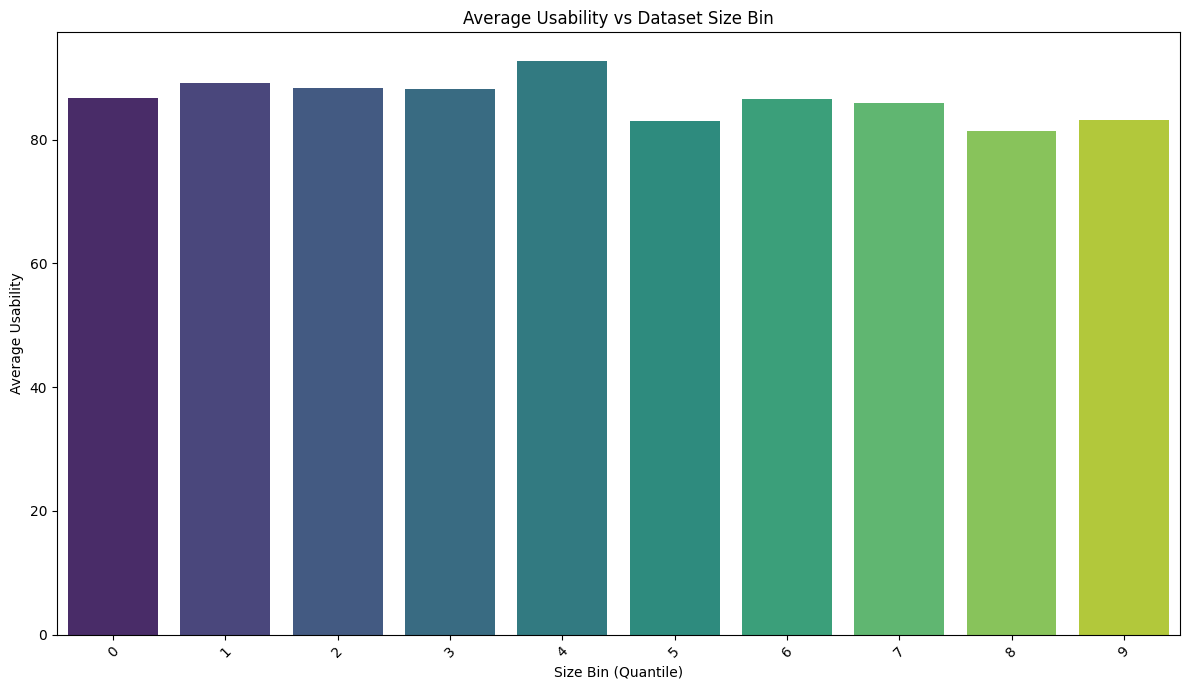

In [37]:
# Create a bar plot of Usability grouped by Size (binned)
# It might be helpful to bin 'Size' for a clearer bar plot
df_filtered['Size_Bin'] = pd.qcut(df_filtered['Size_MB'], q=10, labels=False, duplicates='drop')

# Group by the size bins and calculate the mean Usability
grouped_data = df_filtered.groupby('Size_Bin')['Usability'].mean().reset_index()

# Plot the bar graph
plt.figure(figsize=(12, 7))
sns.barplot(data=grouped_data, x='Size_Bin', y='Usability', palette='viridis')
plt.title('Average Usability vs Dataset Size Bin')
plt.xlabel('Size Bin (Quantile)')
plt.ylabel('Average Usability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

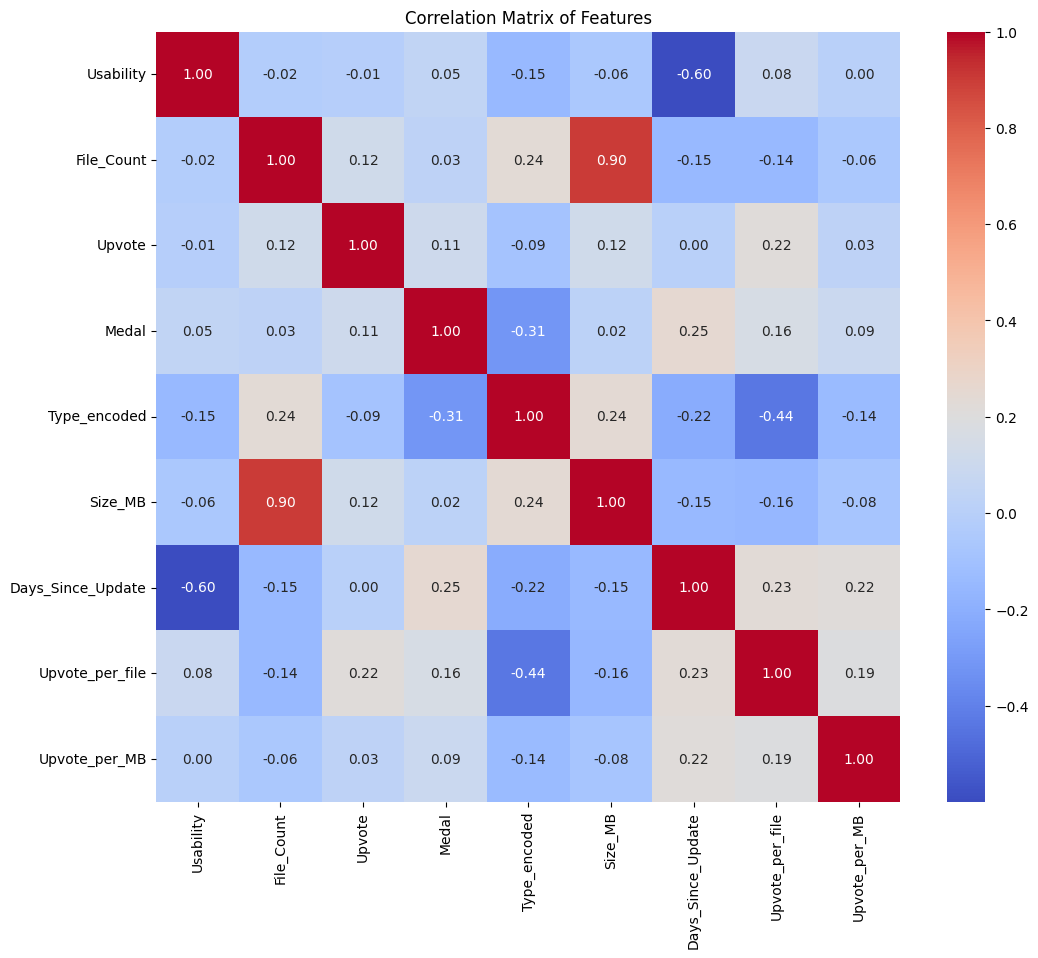


Correlation with Target Variable Upvote'):
Upvote               1.000000
Upvote_per_file      0.217474
File_Count           0.123123
Size_MB              0.122514
Medal                0.108794
Upvote_per_MB        0.031171
Days_Since_Update    0.002616
Usability           -0.006931
Type_encoded        -0.092508
Name: Upvote, dtype: float64

Features strongly correlated with 'Upvote' (absolute correlation > 0.1):


,Upvote
Upvote_per_file,0.217474
File_Count,0.123123
Size_MB,0.122514
Medal,0.108794


In [38]:
# prompt: provide correlation analysis

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Print the correlation matrix (optional, can be large)
# print("\nCorrelation Matrix:")
# print(correlation_matrix)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Optional: Focus on correlations with the target variable
target_correlation = correlation_matrix['Upvote'].sort_values(ascending=False)
print("\nCorrelation with Target Variable Upvote'):")
print(target_correlation)

# Optional: Display correlations above a certain threshold
threshold = 0.10 # Define a threshold for strong correlation
strong_correlations = target_correlation[(target_correlation.abs() > threshold) & (target_correlation.index != 'Upvote')]
print(f"\nFeatures strongly correlated with 'Upvote' (absolute correlation > {threshold}):")
strong_correlations

In [39]:
# prompt: VIF analysis for multicollinearity check

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'df_numeric' contains the numeric columns you want to check for VIF
# Add a constant to the dataframe for VIF calculation
X = add_constant(df_numeric)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(X.shape[1])]

print("\nVariance Inflation Factor (VIF):")
vif_data

# Interpretation of VIF:
# A general rule of thumb for interpreting VIF is as follows:
# VIF = 1: No correlation between the feature and the other features.
# 1 < VIF < 5: Moderate correlation, which does not typically require correction.
# VIF >= 5 (or 10, depending on the source): High correlation, which may indicate multicollinearity and potentially cause issues in regression analysis.

# You might want to remove features with very high VIF values depending on your model and goals.



Variance Inflation Factor (VIF):


,feature,VIF
0,const,191.927487
1,Usability,1.991579
2,File_Count,5.397363
3,Upvote,1.094474
4,Medal,1.235314
5,Type_encoded,1.474368
6,Size_MB,5.471933
7,Days_Since_Update,2.259416
8,Upvote_per_file,1.384969
9,Upvote_per_MB,1.094203


In [40]:
#Identify features to keep based on strong correlation with the target variable
# We already calculated `strong_correlations` which contains features with absolute correlation > threshold
features_to_keep = strong_correlations.index.tolist()

print(f"\nFeatures selected based on strong correlation: {features_to_keep}")



Features selected based on strong correlation: ['Upvote_per_file', 'File_Count', 'Size_MB', 'Medal']


In [42]:
# prompt: GradientBoosting
# RandomForest
# ExtraTrees
# XGBoost
# Bagging
# Ridge
# Lasso
# LinearRegression
# DecisionTree
# SVR
# KNN to predict upvotes

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features (using the ones identified as strongly correlated, plus 'Days_Since_Update' if not included)
# We need to ensure the selected features are in the DataFrame and handle potential missing values
# Let's use 'Usability', 'Days_Since_Update' and 'Size_MB' as a starting point based on the previous analysis,
# assuming they are numeric and have been handled for NaNs in the `df_filtered` dataframe.
# We will also add 'Medal' if it's available and numeric.

features = features_to_keep
# Check if 'Medal' is a valid column and numeric before adding
if 'Medal' in df_filtered.columns and pd.api.types.is_numeric_dtype(df_filtered['Medal']):
    features.append('Medal')

print(f"Features used for prediction: {features}")

# Target variable
target = 'Upvote'

# Drop rows with missing values in selected features or target
df_model = df_filtered.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Bagging": BaggingRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {"MSE": mse, "R2": r2}
        print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

    except Exception as e:
        results[name] = {"Error": str(e)}
        print(f"Error training {name}: {e}")

# Print a summary of results
print("\n--- Model Performance Summary ---")
for name, metrics in results.items():
    if "Error" in metrics:
        print(f"{name}: Error - {metrics['Error']}")
    else:
        print(f"{name}: MSE={metrics['MSE']:.4f}, R2={metrics['R2']:.4f}")

# You can further analyze these results to determine the best performing model
# based on metrics like R2 score (higher is better) and MSE (lower is better).

Features used for prediction: ['Upvote_per_file', 'File_Count', 'Size_MB', 'Medal', 'Medal']

Training Gradient Boosting...
Gradient Boosting - MSE: 2908917.1159, R2: -0.5641

Training Random Forest...
Random Forest - MSE: 4559477.1224, R2: -1.4516

Training Extra Trees...
Extra Trees - MSE: 1316554.4723, R2: 0.2921

Training XGBoost...
Error training XGBoost: 'DataFrame' object has no attribute 'dtype'

Training Bagging...
Bagging - MSE: 13880244.2340, R2: -6.4633

Training Ridge...
Ridge - MSE: 2053861.0370, R2: -0.1043

Training Lasso...
Lasso - MSE: 2054634.4879, R2: -0.1048

Training Linear Regression...
Linear Regression - MSE: 2054901.3465, R2: -0.1049

Training Decision Tree...
Decision Tree - MSE: 1777144.7000, R2: 0.0444

Training SVR...
SVR - MSE: 1969787.9335, R2: -0.0591

Training KNN...
KNN - MSE: 1332471.4840, R2: 0.2835

--- Model Performance Summary ---
Gradient Boosting: MSE=2908917.1159, R2=-0.5641
Random Forest: MSE=4559477.1224, R2=-1.4516
Extra Trees: MSE=1316554.